In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy import linalg
#from scipy import optimize
import matplotlib as mpl
import copy
from collections import defaultdict
from sklearn_extra.cluster import KMedoids
import math
import csv
import matlab.engine
from zoopt import Dimension, Objective, Parameter, ExpOpt
from sklearn import metrics
import matlab.engine

In [2]:
def run_kmedoids(n_clusters, X):
    #kmed = KMedoids(n_clusters = cluster_size, random_state=42).fit(X)
    eng = matlab.engine.start_matlab()
    matlab_X = matlab.double(X.tolist())
    #matlab_labels, matlab_centers = eng.kmedoids(matlab_X, cluster_size, 'Distance', 'Euclidean' ,nargout = 2)
    matlab_labels, matlab_centers = eng.kmedoids(matlab_X, cluster_size, nargout = 2)
    
    centers = []
    for cntr in matlab_centers:
        centers.append(np.array(cntr))
    centers = np.array(centers)
    
    
    tmp_cntrs = []
    for center in centers:
        tmp_cntrs.append(np.sum(center))
    tmp_cntrs = np.array(tmp_cntrs)
    argsort_tmp_cntrs = np.argsort(tmp_cntrs)
    final_cntrs = []
    for i,_ in enumerate(centers):
        final_cntrs.append(centers[argsort_tmp_cntrs[i]])
    final_cntrs = np.array(final_cntrs)
    centers = final_cntrs

    labels = tmp_kmeans(X, centers)
    
    return (labels, centers)


def tmp_kmeans(data, cntrs):
    tmp_labels = []
    for idx,x in enumerate(data):
        if cluster_size == 1:
            tmp_labels.append(0)
        if cluster_size == 2:
            tmp_labels.append(np.argmin([linalg.norm(cntrs[0] - x), linalg.norm(cntrs[1] - x)]))
        if cluster_size == 3:
            tmp_labels.append(np.argmin([linalg.norm(cntrs[0] - x), linalg.norm(cntrs[1] - x), linalg.norm(cntrs[2] - x)]))
        if cluster_size == 4:
            tmp_labels.append(np.argmin([linalg.norm(cntrs[0] - x), linalg.norm(cntrs[1] - x), linalg.norm(cntrs[2] - x), linalg.norm(cntrs[3] - x)]))
        if cluster_size == 5:
            tmp_labels.append(np.argmin([linalg.norm(cntrs[0] - x), linalg.norm(cntrs[1] - x), linalg.norm(cntrs[2] - x), linalg.norm(cntrs[3] - x), linalg.norm(cntrs[4] - x)]))
            
    
    return tmp_labels


def fairness_cost_balance(data, lbls, groups):
    
    npoints = data.shape[0]
    num_groups = np.unique(groups).shape[0]

    ideal_proportion = defaultdict(float)
    for g in range(num_groups):
        ideal_proportion[g] = np.count_nonzero(np.array(groups == g))

    for g in range(num_groups):
        ideal_proportion[g] /= float(npoints)
    
    membership = defaultdict(lambda: defaultdict(float))
    cluster_sizes = defaultdict(float)
    for idx, x in enumerate(data):
        cluster_k = lbls[idx]
        for g in range(num_groups):
            if groups[idx] == g:
                membership[g][cluster_k] += 1.0
                 
        cluster_sizes[cluster_k] += 1.0

    val = float('inf')
    
    for cluster_k in np.unique(lbls):
        for g in range(num_groups):
            if(membership[g][cluster_k] == 0):
                return 0
            
            a = (float(membership[g][cluster_k])/float(cluster_sizes[cluster_k]))/float(ideal_proportion[g])
            b = float(ideal_proportion[g])/(float(membership[g][cluster_k])/float(cluster_sizes[cluster_k]))
            val = min(min(a, b), val)
    
    return val

In [3]:
def obj_func(solution):
    V = np.array(solution.get_x()).reshape((V_size, sample_features))
    X_copy = copy.deepcopy(X)
    X_copy = np.vstack((X_copy,V))
    labels, centers = run_kmedoids(k, X_copy)
    cost = fairness_cost_balance(X, labels, groups)
    return cost

In [4]:
V_size = 200 #50, 200, 100 
k = 2
cluster_size = k
dataset_name = 'creditcard'

X = []
with open('./datafiles/data_' + dataset_name + '.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        X.append(row)
X = np.array(X).astype(np.float)
print(X.shape)

sample_size, sample_features = X.shape[0], X.shape[1]

groups = []
with open('./datafiles/groups_'+ dataset_name + '.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        groups.append(row)
groups = np.array(groups).astype(np.float)
groups = groups - 1

if dataset_name == 'adultm' or dataset_name == 'seeds' or dataset_name == 'bank' or dataset_name == 'bankm':
    groups = groups.reshape((groups.shape[-1], 1))
print(groups.shape)

(30000, 23)
(30000, 1)


In [5]:
lbls, cntrs = run_kmedoids(k, X)

In [6]:
print(fairness_cost_balance(X, lbls, groups))

0.8611658242781424


[zoopt] sequential random embedding 0
[zoopt] expected remaining running time: 00:23:14
[zoopt] budget 100, fx result: 0.0
[zoopt] x: [-0.6016095325443329, 2.331613130344774, 16.49314710943259, -8.15989508474258, -16.74410665683819, 2.103678799400072, -13.106777072751786, 17.387822841777496, 3.6328461338453053, -6.144995638034118, 8.22612846644832]
[zoopt] budget 200, fx result: 0.0
[zoopt] x: [-0.956954391663055, -6.118765200102057, 14.544722000109836, -3.7577957239265762, -1.2151242017368755, 7.777234148978126, -16.4832747341977, 12.275362943305828, 16.041137907406537, -18.451246146521328, 4.5556610031717995]
[zoopt] x: array([ 9.92867986, -4.32428063, -4.18227211, ..., -4.12722063,
        3.10235334,  1.6678875 ])
[zoopt] value: 0.0
[zoopt] The best solution is:
[zoopt] x: array([ 9.92867986, -4.32428063, -4.18227211, ..., -4.12722063,
        3.10235334,  1.6678875 ])
[zoopt] value: 0.0


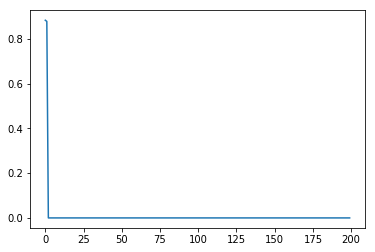

[zoopt] Best 1 result: 0.0 +- 0.0


In [7]:
dim_size = V_size*sample_features  # dimensions
dim_regs = [[-20,20]] * dim_size  # dimension range #-5,10
dim_tys = [True] * dim_size  # dimension type : real
dim = Dimension(dim_size, dim_regs, dim_tys)  # form up the dimension object
objective = Objective(obj_func, dim)  # form up the objective function

low_dims_size = 10 #100

# setup algorithm parameters
budget = 200 #4200,  2000  # number of calls to the objective function
parameter = Parameter(budget=budget, seed=42, exploration_rate=0.3, intermediate_result = True, high_dim_handling=True, reducedim=True, num_sre=1,
                      low_dimension=Dimension(low_dims_size, [[-20,20]] * low_dims_size, [True] * low_dims_size)) #3,  2
solution_list = ExpOpt.min(objective, parameter, repeat=1, plot=True) #2

In [8]:
V = np.array(solution_list[0].get_x()).reshape((V_size, sample_features))
X_copy = copy.deepcopy(X)
X_copy = np.vstack((X_copy,V))
labels, centers = run_kmedoids(k, X_copy)
cost = fairness_cost_balance(X, labels, groups)
print(cost)
np.save('datafiles/adversarial_centers/' + dataset_name + '_centers_' + str(k), centers)

0
